In [1]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import numpy as np
import cv2
%matplotlib inline

In [2]:
TRAIN_DIR = "train/"
TEST_DIR = "test/"
IMAGE_SIZE = 50

In [3]:
train_image_file_names = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)][0:3000] 
test_image_file_names = [TEST_DIR+i for i in os.listdir(TEST_DIR)][0:1000]

In [4]:
def resize_image(image_file_names, height, width):
    images = []
    
    graph = tf.Graph()
    with graph.as_default():
        file_name = tf.placeholder(dtype=tf.string)
        file = tf.read_file(file_name)
        image = tf.image.decode_jpeg(file)
        image = tf.image.resize_image_with_crop_or_pad(image, height, width)
    
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer()  
        for i in range(len(image_file_names)):
            images.append(session.run(image, feed_dict={file_name: image_file_names[i]}))
            if (i+1) % 1000 == 0:
                print('Images processed: ',i+1)
        
        session.close()
    
    return images

In [5]:
processed_train_images = resize_image(train_image_file_names,500,500)
processed_test_images = resize_image(test_image_file_names, 500, 500)

Images processed:  1000
Images processed:  2000
Images processed:  3000
Images processed:  1000


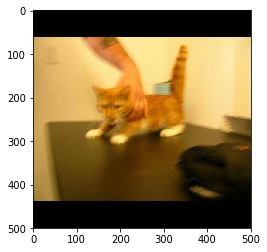

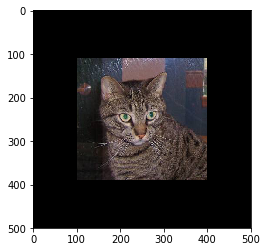

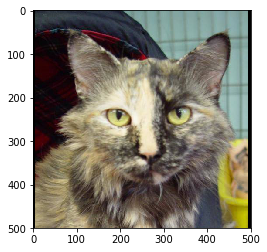

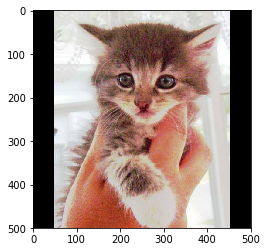

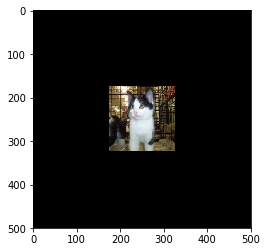

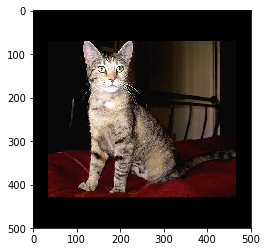

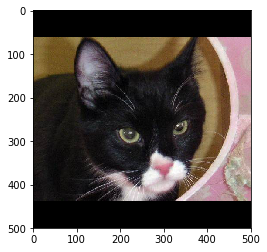

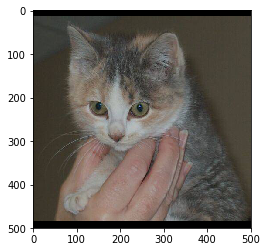

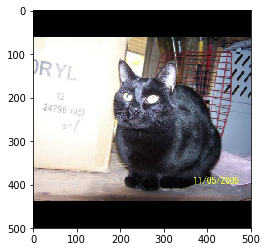

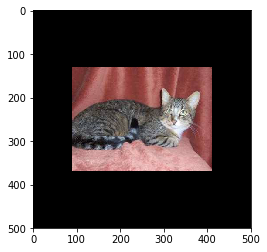

In [6]:
for i in range(10):
    plt.imshow(processed_train_images[i])
    plt.show()

In [7]:
labels = [[1., 0.] if 'dog' in name else [0., 1.] for name in train_image_file_names]

In [8]:
def resize_and_process_images(filepath):
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
    return image2

<class 'numpy.ndarray'>


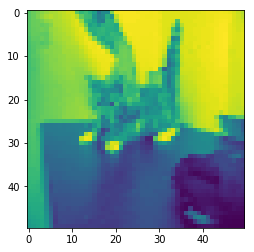

<class 'numpy.ndarray'>


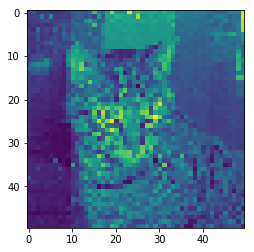

<class 'numpy.ndarray'>


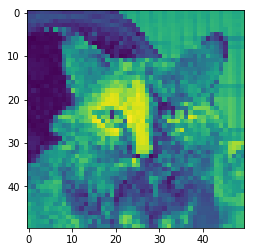

<class 'numpy.ndarray'>


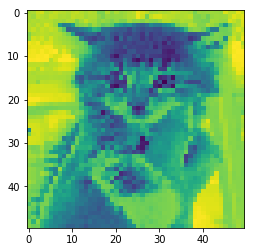

<class 'numpy.ndarray'>


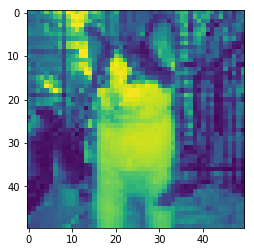

<class 'numpy.ndarray'>


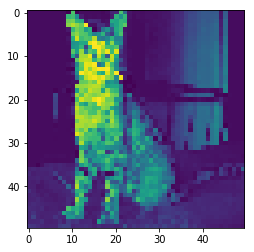

<class 'numpy.ndarray'>


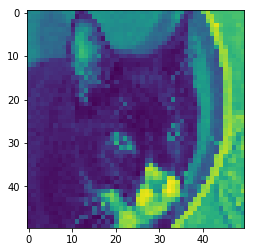

<class 'numpy.ndarray'>


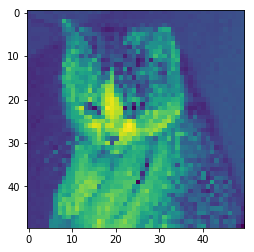

<class 'numpy.ndarray'>


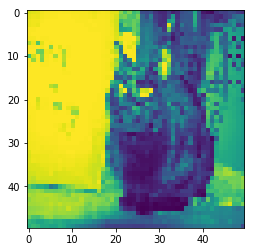

<class 'numpy.ndarray'>


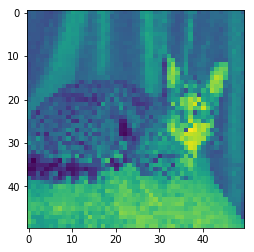

<class 'numpy.ndarray'>


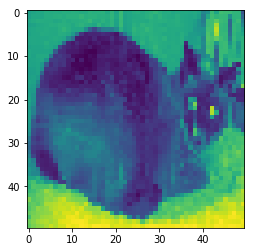

<class 'numpy.ndarray'>


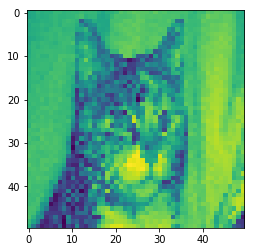

<class 'numpy.ndarray'>


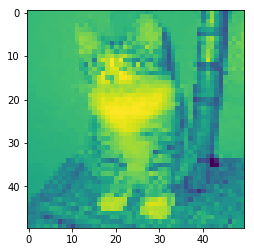

<class 'numpy.ndarray'>


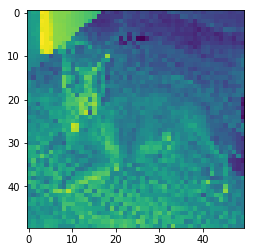

<class 'numpy.ndarray'>


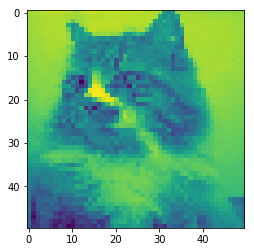

<class 'numpy.ndarray'>


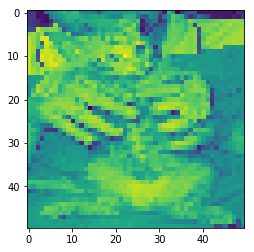

<class 'numpy.ndarray'>


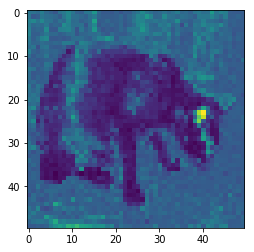

<class 'numpy.ndarray'>


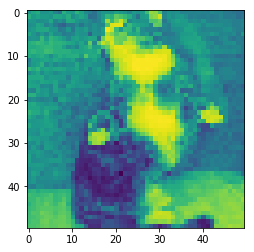

<class 'numpy.ndarray'>


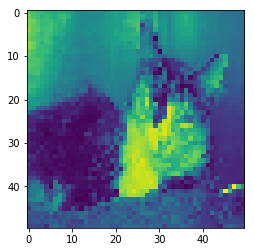

<class 'numpy.ndarray'>


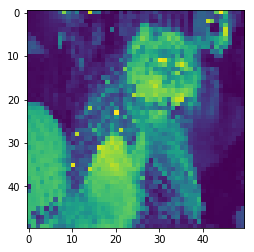

In [9]:
for i in range(20):
    image = resize_and_process_images(train_image_file_names[i])
    print (type(image))
    plt.imshow(image)
    plt.show()